Cantidad de filas de entrenamiento:  379


  0%|          | 0/150000 [00:00<?, ?it/s]

X_test ACCURACY post-training:  95.78947368421052
X_train ACCURACY post-training:  96.30606860158312


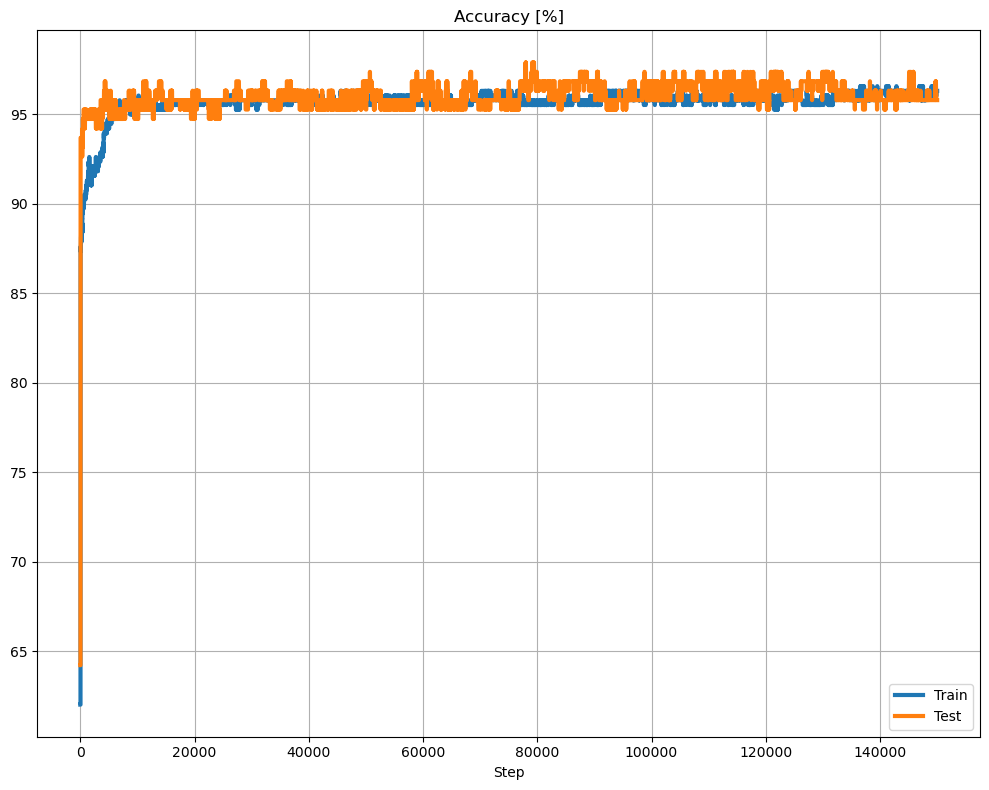

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

# Cargar el archivo en una variable
df2 = pd.read_csv('cancer_de_mama_limpio_top10.csv')

# Extraer variables de entrada (todas las filas, columnas de 2 a 10)
X = df2.iloc[:, 2:11].values

# Extraer columna de salida (todas las filas, columna 'diagnosis')
Y = df2.iloc[:, 1].values  

# Normalizar las características con StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en un conjunto de entrenamiento y uno de prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=42)

# Número de registros de entrenamiento
n = X_train.shape[0]
print('Cantidad de filas de entrenamiento: ', n)

# Funciones de activación
relu = lambda x: np.maximum(x, 0)
logistic = lambda x: 1 / (1 + np.exp(-x))

# Semilla para reproducibilidad
np.random.seed(2)

# Construir red neuronal con pesos y sesgos inicializados aleatoriamente
w_hidden = (np.random.rand(3, 9) * 2) - 1  
w_output = (np.random.rand(1, 3) * 2) - 1  
b_hidden = (np.random.rand(3, 1) * 2) - 1  
b_output = (np.random.rand(1, 1) * 2) - 1  

# Funcion que corre la red neuronal con los datos de entrada para predecir la salida
def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden        
    A1 = relu(Z1)
    Z2 = w_output @ A1 + b_output       
    A2 = logistic(Z2)
    return Z1, A1, Z2, A2

# Tasa de aprendizaje
L = 0.01

# Derivadas de las funciones de activación
d_leaky_relu = lambda x: x > 0
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

# Devuelve pendientes para pesos y sesgos usando la regla de la cadena
def backward_prop(Z1, A1, Z2, A2, X, Y):
    dC_dA2 = 2 * A2 - 2 * Y
    dA2_dZ2 = d_logistic(Z2)
    dZ2_dA1 = w_output
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T
    dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2
    dC_dA1 = dC_dA2 @ dA2_dZ2 @ dZ2_dA1
    dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T
    dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2

# Listas para almacenar la precisión
accuracy_train_l = []
accuracy_test_l = []

# Ejecutar descenso de gradiente
for i in tqdm(range(150_000)):
    # Seleccionar aleatoriamente un registro de entrenamiento
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    # Pasar datos seleccionados aleatoriamente a través de la red neuronal
    Z1, A1, Z2, A2 = forward_prop(X_sample)
    
    # Retropropagación y cálculo de pendientes para pesos y sesgos
    dW1, dB1, dW2, dB2 = backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)
    
    # Actualizar pesos y sesgos
    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_output -= L * dW2
    b_output -= L * dB2
    
    # Cálculo de precisión en el conjunto de prueba
    test_predictions = forward_prop(X_test.transpose())[3]
    test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y_test)
    accuracy_test = np.mean(test_comparisons) * 100
    accuracy_test_l.append(accuracy_test)

    # Cálculo de precisión en el conjunto de entrenamiento
    train_predictions = forward_prop(X_train.transpose())[3]
    train_comparisons = np.equal((train_predictions >= .5).flatten().astype(int), Y_train)
    accuracy_train = np.mean(train_comparisons) * 100
    accuracy_train_l.append(accuracy_train)

# Imprimir la precisión final
print("X_test ACCURACY post-training: ", accuracy_test_l[-1])
print("X_train ACCURACY post-training: ", accuracy_train_l[-1])

# Graficar la precisión
fmt_train = {
    'color': 'tab:blue',
    'ls': 'solid',
    'lw': 3,
}

fmt_test = {
    'color': 'tab:orange',
    'ls': 'solid',
    'lw': 3,
}

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(accuracy_train_l, label='Train', **fmt_train)
ax.plot(accuracy_test_l, label='Test', **fmt_test)


ax.grid(which='both')
ax.legend()
ax.set_title('Accuracy [%]')
ax.set_xlabel('Step')

fig.tight_layout()
plt.show()


## Luego de desarrollar nuestra Red Neuronal, viendo el porcentaje de aciertos y el gráfico, ¿nuestro modelo presenta overfitting?. 
El overfitting es cuando una red una de ajusta demasiado bien a los datos de entrenamiento. Una forma de detectar el sobreajuste es observando si el porcentaje de aciertos en el conjunto de entrenamiento es significativamente mayor que en el conjunto de prueba, especialmente si esta diferencia se amplía al aumentar las épocas de entrenamiento. También es indicativo de sobreajuste si el rendimiento en el conjunto de prueba se estabiliza mientras que el del entrenamiento continúa mejorando.

Existen varias estrategias para prevenir o detectar el sobreajuste en redes neuronales:

- Dropout: Esta técnica consiste en desactivar aleatoriamente algunas neuronas durante el entrenamiento, lo que ayuda a evitar la dependencia de neuronas específicas.

- Reducir la complejidad de la red neuronal: Una forma de lograrlo es disminuir el número de neuronas en las capas ocultas, lo que impide que la red aprenda en exceso sobre datos específicos.

- Ajustar el número de épocas: Limitar la cantidad de iteraciones de entrenamiento puede ayudar a detener el proceso antes de que la red continúe entrenándose sin mejoras en el conjunto de prueba.

- Aumentar la cantidad de datos: Contar con más muestras puede disminuir la probabilidad de sobreajuste, ya que se facilita la generalización.

# Conclusión Final
Desarrollar una red neuronal desde cero nos permitió entender en profundidad cómo funcionan las redes neuronales en cada paso del proceso, desde la inicialización de pesos y sesgos hasta el forward y el backward. Al construir manualmente cada función de activación y sus derivadas, adquirí una comprensión mucho más detallada de cómo los gradientes afectan el ajuste de los pesos y de cómo se optimizan los modelos de aprendizaje.
Comparado con el uso la  librería de scikit-learn, crear una red neuronal manualmente ofrece ventajas significativas en términos de aprendizaje. Trabajar desde cero ayuda a entender mejor las matemáticas y la lógica detrás del entrenamiento de los modelos. La principal desventaja de este enfoque es que resulta mucho más laborioso y es muy propenso a errores, ya que requiere gestionar manualmente cada cálculo y ajuste de parámetros.
